In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [212]:
speedups_per_bs = {
    "A100_float32": {
        "SDPA vs Vanilla": [47.69, 52.46, 53.23, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [42.45, 54.85, 54.47, 0, 0, 0],
        "SDPA vs xFormers": [32.64, 36.07, 36.38, 37.53, 38.04, 38.05],
        "SDPA + torch.compile vs xFormers": [25.91, 39.29, 38.06, 38.32, 38.99, 39.03],
    },
    "A100_float16": {
        "SDPA vs Vanilla": [26.39, 26.19, 27.72, 28.50, 0, 0],
        "SDPA + torch.compile vs Vanilla": [8.18, 33.02, 32.03, 30.34, 0, 0],
        "SDPA vs xFormers": [26.67, 0.51, -0.14, 0.15, -0.45, -0.99],
        "SDPA + torch.compile vs xFormers": [8.52, 9.72, 5.83, 2.73, 2.67, 3.01],
    },
    "4090_float32": {
        "SDPA vs Vanilla": [18.59, 24.65, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [19.86, 28.02, 0, 0, 0],
        "SDPA vs xFormers": [9.62, 9.65, 13.44, 14.19, 13.86],
        "SDPA + torch.compile vs xFormers": [11.02, 13.68, 18.19, 16.34, 18.96],
    },
    "4090_float16": {
        "SDPA vs Vanilla": [12.08, 20.61, 27.29, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [14.54, 23.57, 31.75, 0, 0, 0],
        "SDPA vs xFormers": [1.26, 0.60, -1.96, -2.28, -2.13, -2.78],
        "SDPA + torch.compile vs xFormers": [4.02, 4.30, 4.31, -0.47, 2.72, -0.49],
    },
    "3090_float32": {
        "SDPA vs Vanilla": [13.82, 17.72, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [14.95, 20.27, 0, 0, 0],
        "SDPA vs xFormers": [9.88, 12.96, 13.71, 15.21, 14.23],
        "SDPA + torch.compile vs xFormers": [11.06, 15.66, 16.44, 17.69, 16.98],
    },
    "3090_float16": {
        "SDPA vs Vanilla": [21.41, 21.95, 22.34, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [25.60, 26.21, 26.54, 0, 0, 0],
        "SDPA vs xFormers": [-0.90, -0.47, 0.00001, 0.00001, 0.09, 0.40],
        "SDPA + torch.compile vs xFormers": [4.48, 5.01, 5.40, 2.96, 5.46, 7.28],
    },
    "V100_float32": {
        "SDPA vs Vanilla": [8.11, 8.59, 0, 0, 0],
        "SDPA + torch.compile vs Vanilla": [10.00, 10.83, 0, 0, 0],
        "SDPA vs xFormers": [0.5, 1.17, 1.63, 1.32, 0.31],
        "SDPA + torch.compile vs xFormers": [2.63, 3.59, 3.69, 3.87, 2.87],
    },
}

In [97]:
bs = [1, 4, 8, 16, 32, 64]

In [98]:
import matplotlib as mpl

In [99]:
mpl.rcParams.update({'font.size': 15})

In [186]:
# my_cmap = mpl.colormaps['viridis']   # TODO: use materials, maybe.

In [194]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [297]:
def plot_speedups(gpu, dtype, ymin=None, ymax=58, caption=False):
    key = f"{gpu}_{dtype}"
    num_measures = len(next(iter(speedups_per_bs[key].items()))[1])
    x = np.arange(num_measures)  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(constrained_layout=True, figsize=(12,8))
    plt.grid(linestyle=':', linewidth=1)

    ooms_at = 999
    for i, (attribute, measurement) in enumerate(speedups_per_bs[f"{gpu}_{dtype}"].items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute) #color=my_cmap(i/4))
        
        for measure_i, (measure, rect) in enumerate(zip(measurement, rects)):
            if measure == 0:
                ooms_at = min(ooms_at, bs[measure_i])
                x_label, y_label = rect.xy
                y_label += 0.25
                ax.annotate("Vanilla\nOOM", (x_label, y_label), rotation=60, size="x-small", color=default_colors[i])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Speedup (%)')
    ax.set_xlabel('Batch Size')
    ax.set_title(f'Diffusers Inference Speedup vs Vanilla and xFormers Attention ({gpu}, {dtype})')
    ax.set_xticks(x + width*1.5, (str(bs[x]) for x in range(num_measures)))
    ax.legend(loc='best') #, ncol=4)

    plt.ylim((None, ymax))
    
    if caption:
        max_bs = bs[num_measures-1]
        fig.supxlabel(
            f"""
            Diffusers Inference Speedup with PyTorch 2.0 Accelerated Transformers Technology on {gpu} using {dtype}.
            Vanilla attention runs out of memory for batch sizes {ooms_at} and higher, while xFormers and PyTorch 2.0 can reach batch sizes of {max_bs}.
            """, size='smaller')

    plt.show()
    fig.savefig(f"{gpu}_{dtype}.pdf", bbox_inches="tight")
    fig.savefig(f"{gpu}_{dtype}.png", bbox_inches="tight")
    return fig

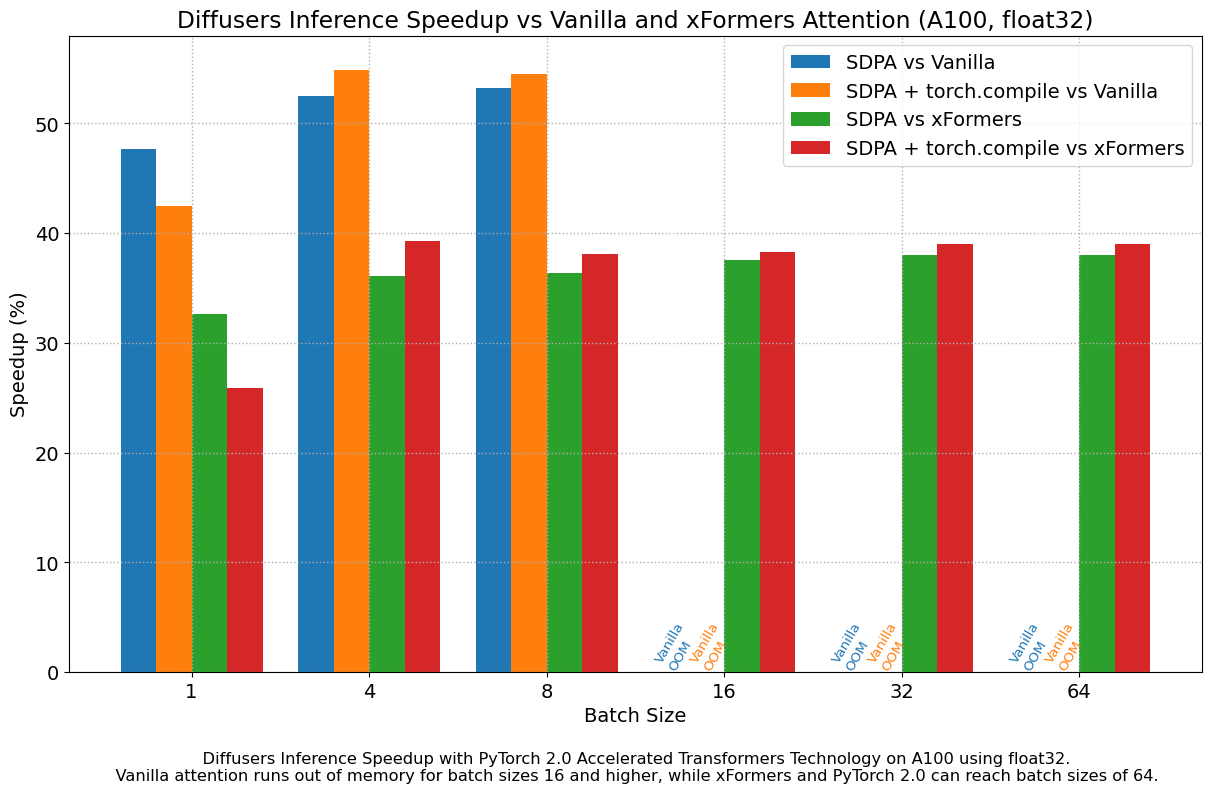

In [298]:
fig = plot_speedups(
    "A100",
    "float32",
    caption=True,
)


In [299]:
import itertools

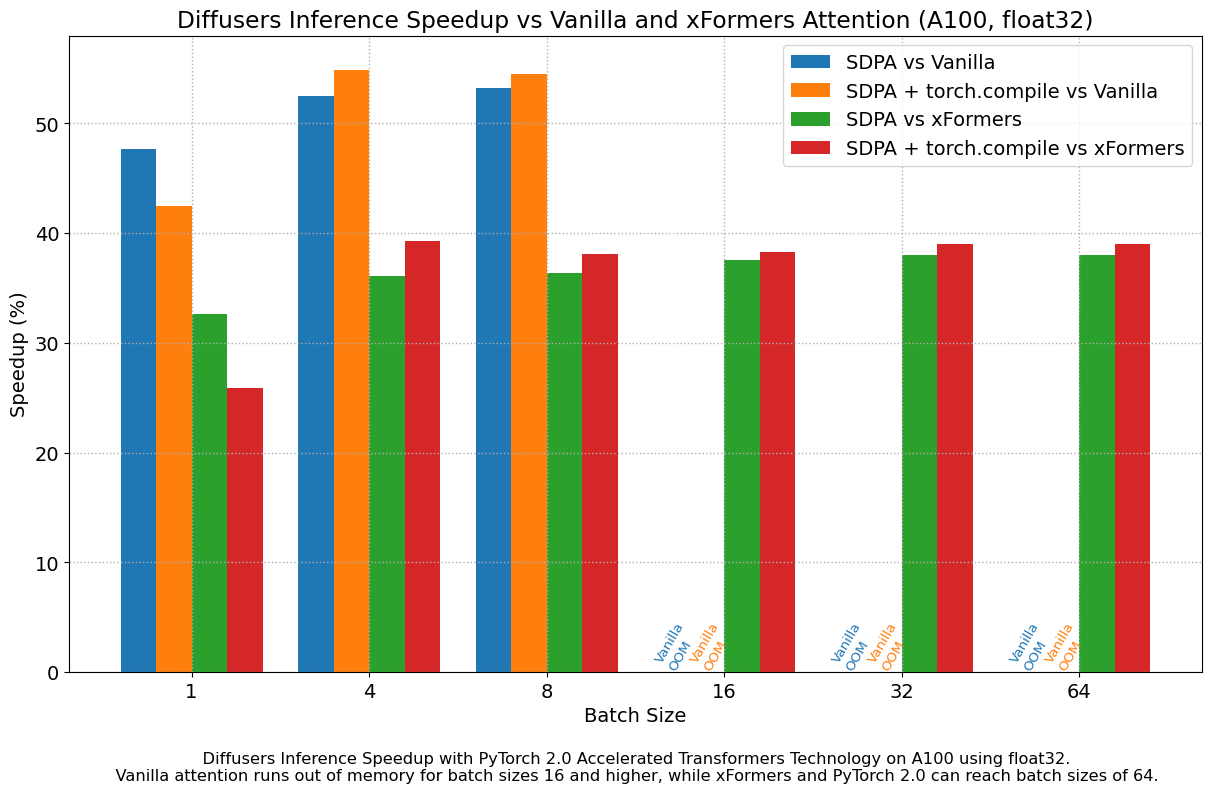

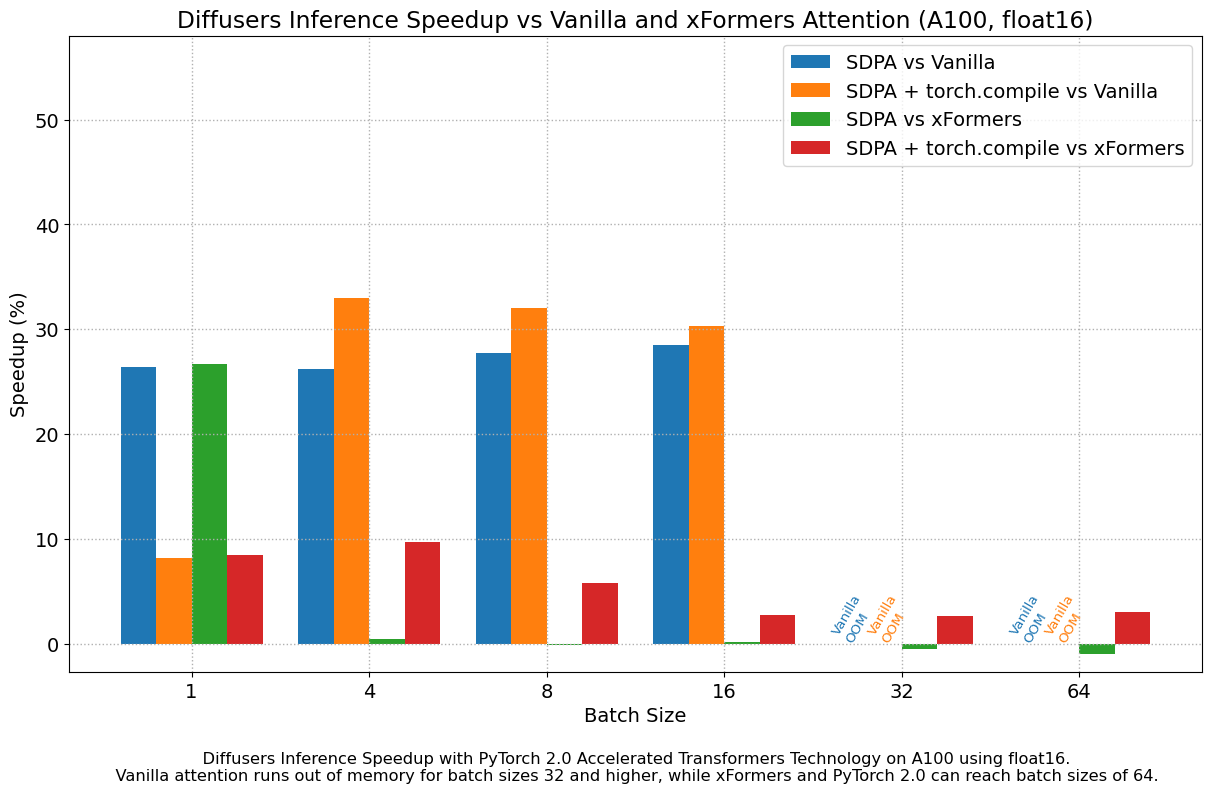

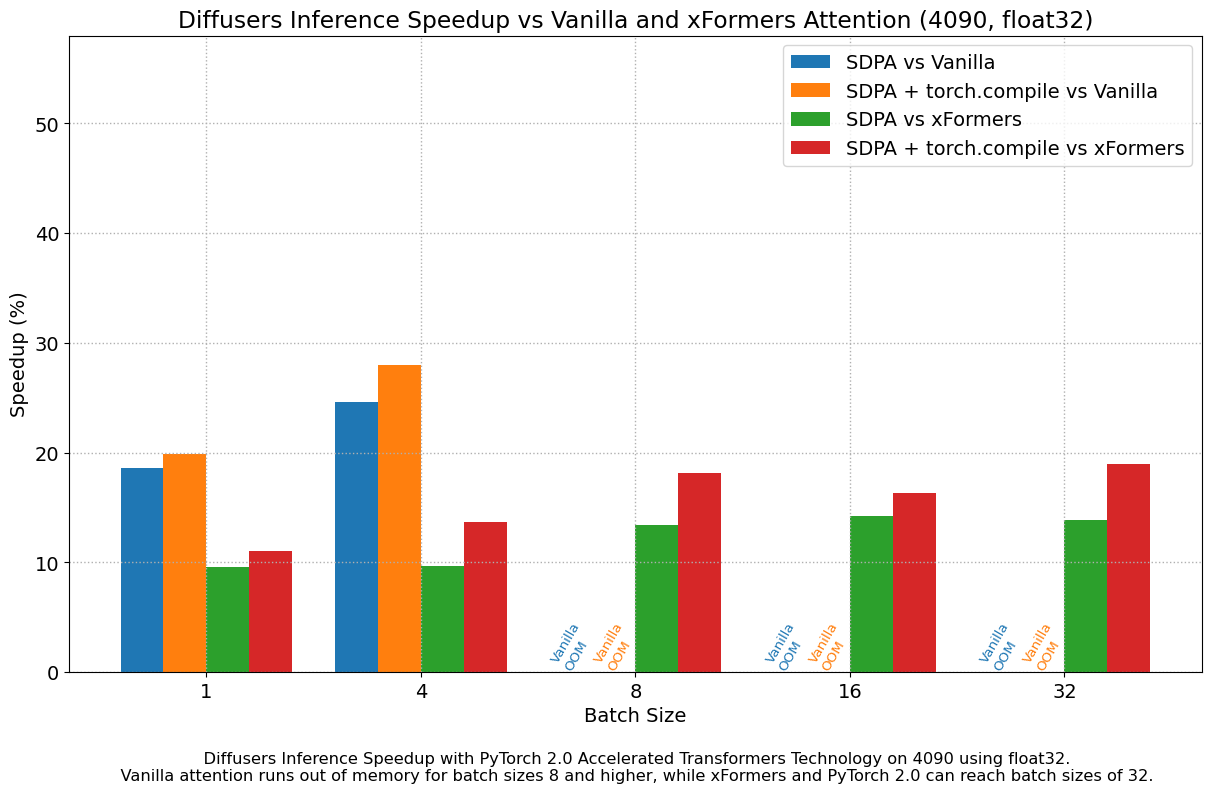

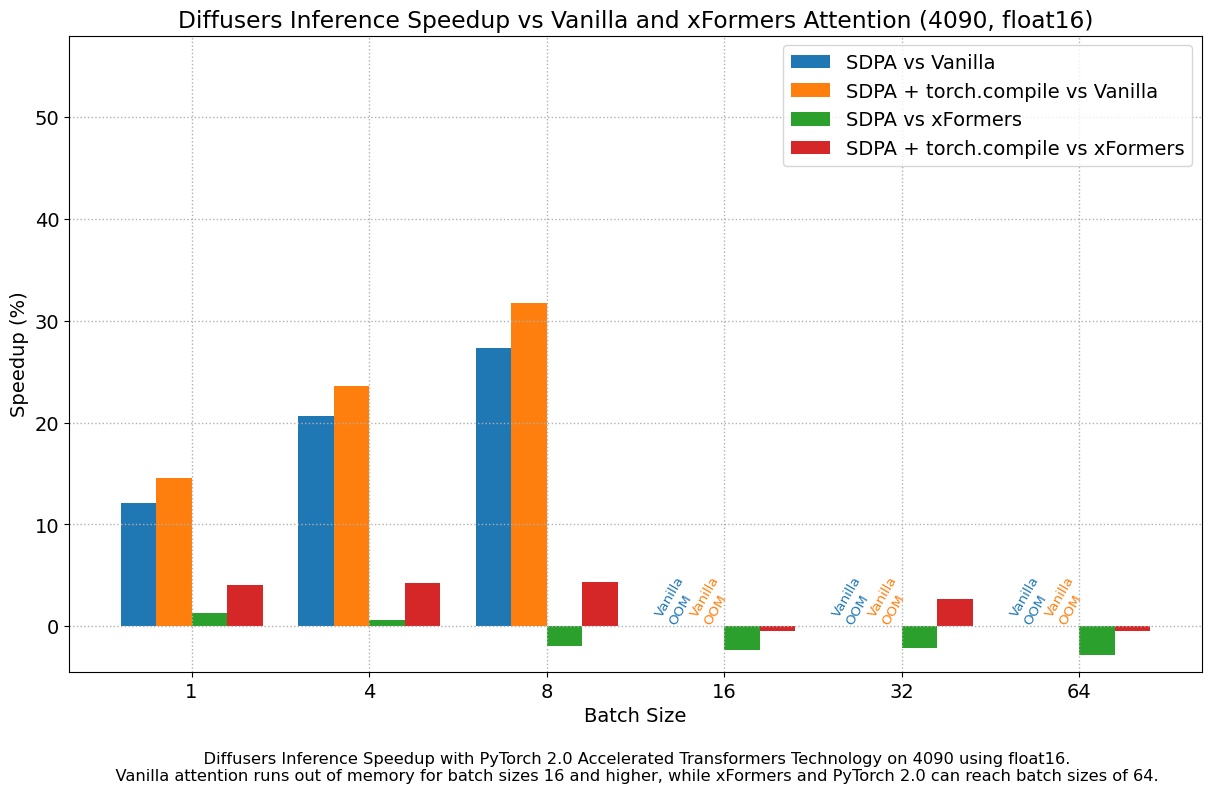

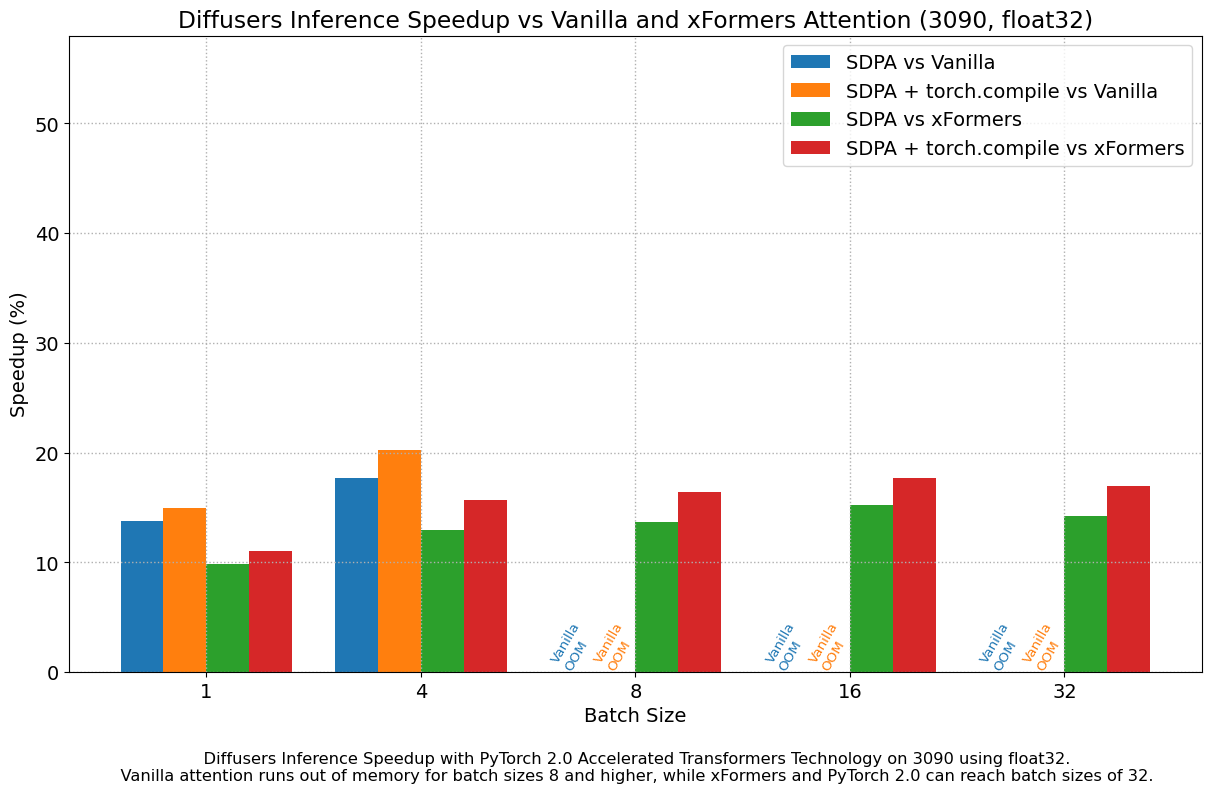

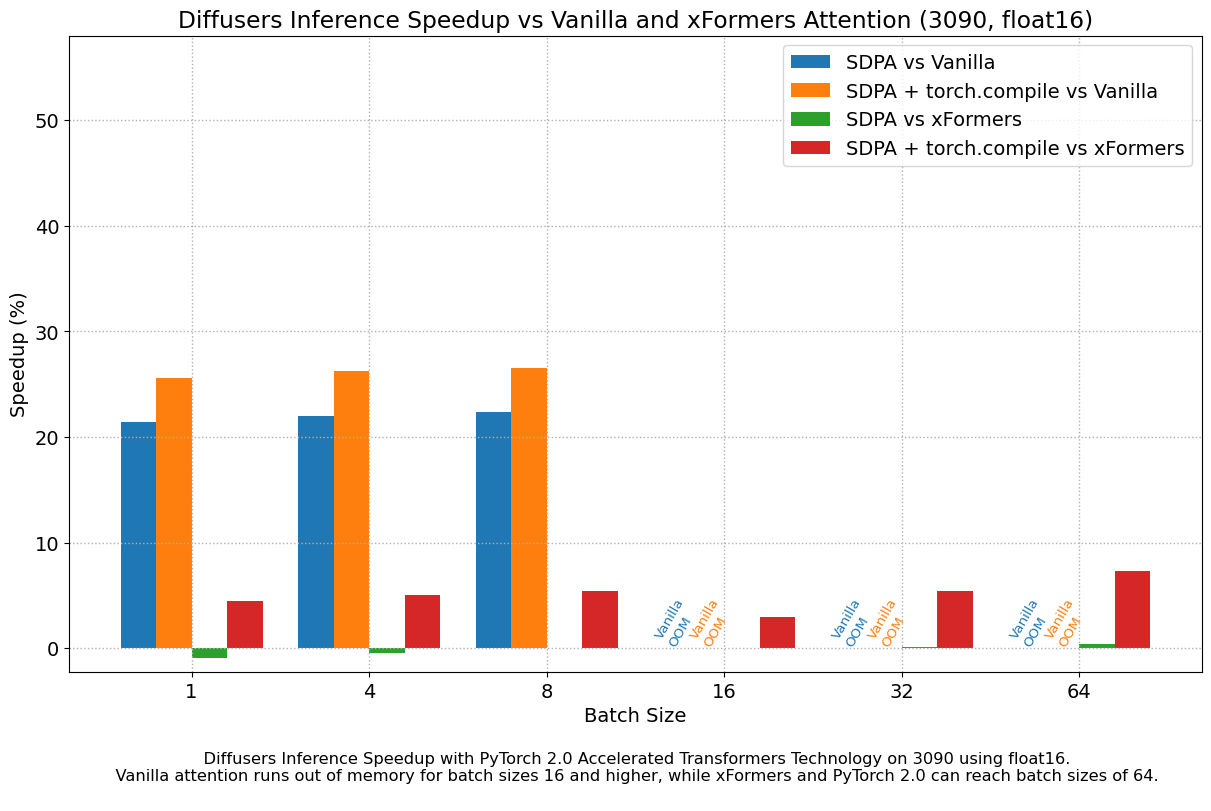

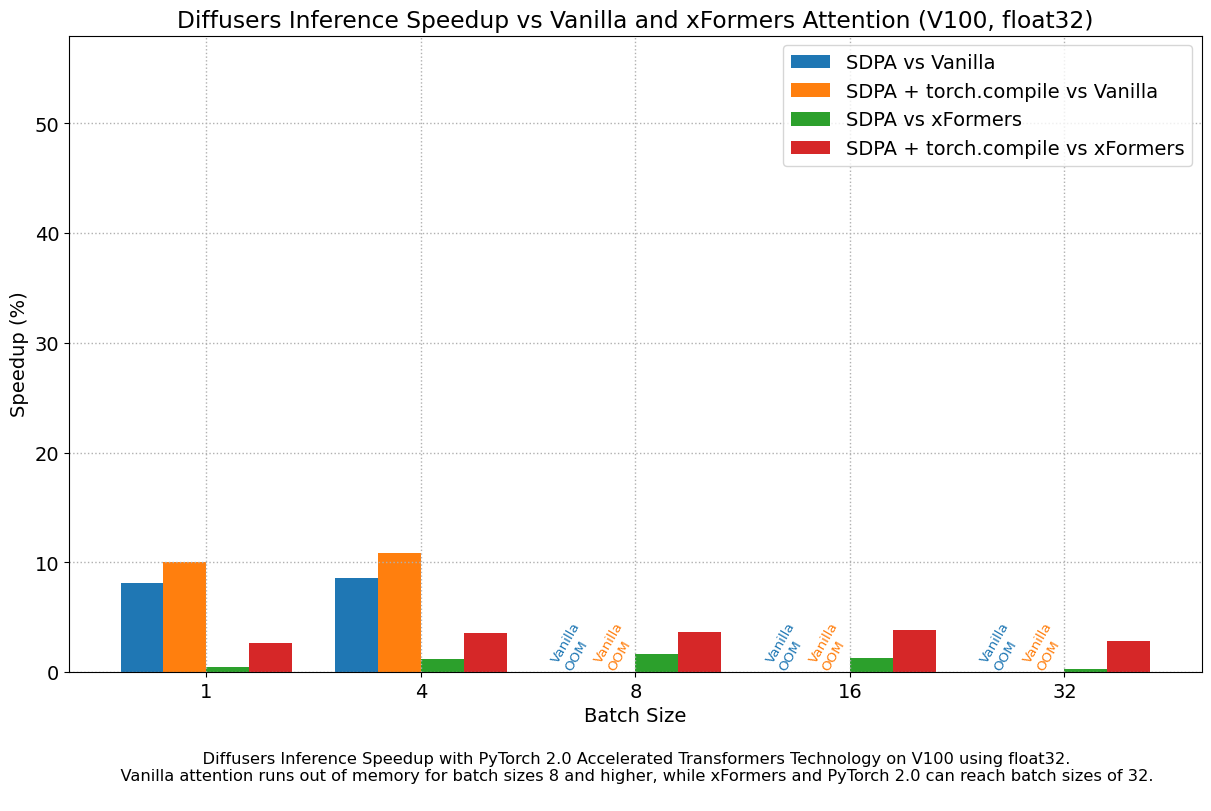

In [300]:
cards = ["A100", "4090", "3090", "V100"]
dtypes = ["float32", "float16"]
for gpu, dtype in itertools.product(cards, dtypes):
    if gpu == "V100" and dtype == "float16":
        continue  # no data
    plot_speedups(gpu, dtype, caption=True)

Let's now see speedups over xFormers for a bunch of cards at given batch size (8 for this example).

In [292]:
all_cards = ["T4", "V100", "3090", "3090Ti", "4090", "A10", "A100"]
speedups_over_xformers = {
    "float32_8": {
        "SDPA": [-0.74, 1.32, 13.71, 12.87, 13.44, 22.53, 36.38],
        "SDPA + torch.compile()": [0.83, 3.87, 16.44, 15.66, 18.19, 21.94, 38.06],
    },
    "float16_8": {
        "SDPA": [-0.5, 1.15, -0.47, -0.51, -1.96, -2.79, -0.14],
        "SDPA + torch.compile()": [3.34, 6.59, 5.01, 4.84, 4.31, 3.53, 5.83],
    }
}

In [293]:
mpl.rcParams.update({'font.size': 14})

In [294]:
def plot_speedups_per_gpu(dtype, bs="8", ymin=-5, ymax = 40, scale_hint=False):
    key = f"{dtype}_{bs}"
    num_measures = len(next(iter(speedups_over_xformers[key].items()))[1])
    x = np.arange(num_measures)  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    plt.grid(linestyle=':', linewidth=1)

    for i, (attribute, measurement) in enumerate(speedups_over_xformers[key].items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute) #, color=my_cmap(i/4))
    #     ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Speedup (%)')
    ax.set_xlabel('GPU')
    ax.set_title(f'Diffusers Speedup vs xFormers using \nPyTorch 2.0 Accelerated Transformer Technology ({dtype}, bs={bs})')
    ax.set_xticks(x + width/2, (all_cards[x] for x in range(num_measures)))
    ax.legend(loc='best') #, ncol=4)

    # place a text box
    if scale_hint:
        textstr = "Same scale as float32 plot"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    plt.ylim((ymin, ymax))
    plt.show()
    fig.savefig(f"{dtype}_{bs}.pdf", bbox_inches="tight")
    fig.savefig(f"{dtype}_{bs}.png", bbox_inches="tight")
    return fig

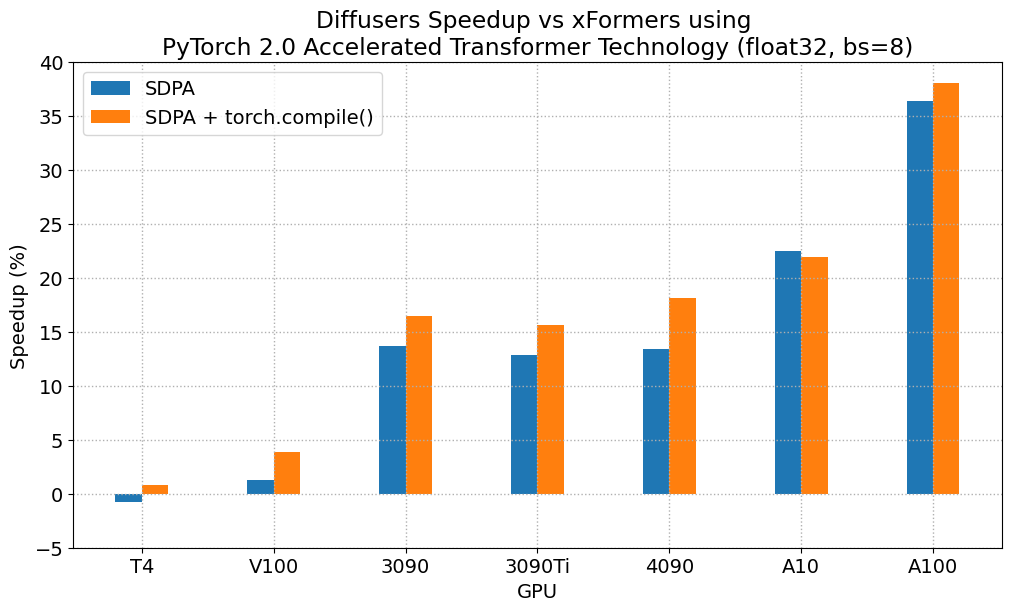

In [295]:
plot_speedups_per_gpu("float32");

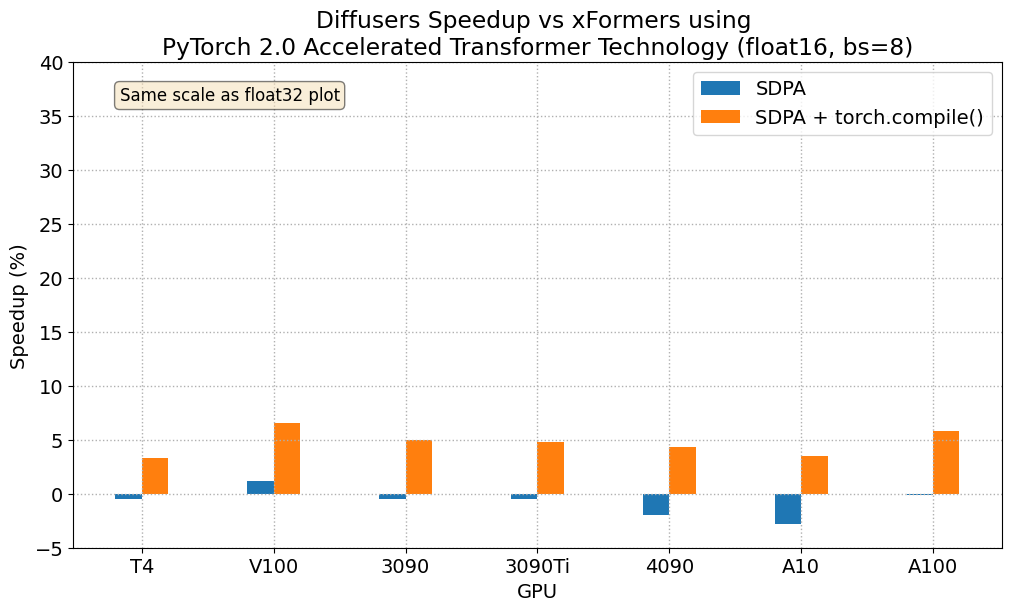

In [296]:
plot_speedups_per_gpu("float16", scale_hint=True);